In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        #self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.game_location = {'top': 500, 'left': 50, 'width': 700, 'height': 300}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [3]:
env = WebGame()

In [4]:
obs=env.get_observation()

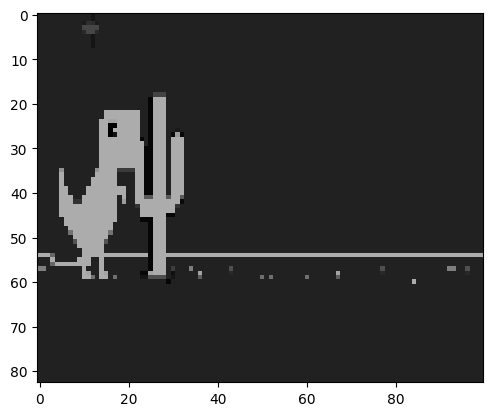

In [5]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [ ]:
done, done_cap = env.get_done()

In [ ]:
plt.imshow(done_cap)

In [ ]:
pytesseract.image_to_string(done_cap)[:4]

In [ ]:
done

In [ ]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

# 3. Train the Model

## 3.1 Create Callback

In [3]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [ ]:
env_checker.check_env(env)

In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [6]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [7]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [8]:
env = WebGame()

In [9]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\SAMEER TALWAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 13.97GB
  warnings.warn(


In [10]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 29       |
|    total_timesteps  | 43       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 56       |
|    total_timesteps  | 91       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.986    |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.3     |
|    ep_rew_mean      | 12.3     |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 1        |
|    time_elapsed     | 596      |
|    total_timesteps  | 1083     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00376  |
|    n_updates        | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.3     |
|    ep_rew_mean      | 12.3     |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 1        |
|    time_elapsed     | 623      |
|    total_timesteps  | 1130     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0036   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 1        |
|    time_elapsed     | 1017     |
|    total_timesteps  | 1830     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000397 |
|    n_updates        | 207      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 1        |
|    time_elapsed     | 1043     |
|    total_timesteps  | 1879     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00017  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.755    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 1        |
|    time_elapsed     | 1445     |
|    total_timesteps  | 2578     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.59e-05 |
|    n_updates        | 394      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1        |
|    time_elapsed     | 1471     |
|    total_timesteps  | 2625     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.686    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 1        |
|    time_elapsed     | 1867     |
|    total_timesteps  | 3307     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88e-06 |
|    n_updates        | 576      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.681    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 1        |
|    time_elapsed     | 1893     |
|    total_timesteps  | 3353     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5e-06    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.615    |
| time/               |          |
|    episodes         | 344      |
|    fps              | 1        |
|    time_elapsed     | 2291     |
|    total_timesteps  | 4052     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64e-05 |
|    n_updates        | 762      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.611    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 1        |
|    time_elapsed     | 2318     |
|    total_timesteps  | 4098     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.82e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 408      |
|    fps              | 1        |
|    time_elapsed     | 2715     |
|    total_timesteps  | 4796     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.15e-06 |
|    n_updates        | 948      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.54     |
| time/               |          |
|    episodes         | 412      |
|    fps              | 1        |
|    time_elapsed     | 2742     |
|    total_timesteps  | 4846     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.48e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.7     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.473    |
| time/               |          |
|    episodes         | 472      |
|    fps              | 1        |
|    time_elapsed     | 3144     |
|    total_timesteps  | 5545     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.83e-06 |
|    n_updates        | 1136     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.7     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 476      |
|    fps              | 1        |
|    time_elapsed     | 3172     |
|    total_timesteps  | 5594     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.26e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.8     |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.401    |
| time/               |          |
|    episodes         | 536      |
|    fps              | 1        |
|    time_elapsed     | 3576     |
|    total_timesteps  | 6304     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.33e-06 |
|    n_updates        | 1325     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.395    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 1        |
|    time_elapsed     | 3609     |
|    total_timesteps  | 6367     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.52e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.328    |
| time/               |          |
|    episodes         | 600      |
|    fps              | 1        |
|    time_elapsed     | 4009     |
|    total_timesteps  | 7073     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.98e-06 |
|    n_updates        | 1518     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.323    |
| time/               |          |
|    episodes         | 604      |
|    fps              | 1        |
|    time_elapsed     | 4037     |
|    total_timesteps  | 7125     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.77e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.256    |
| time/               |          |
|    episodes         | 664      |
|    fps              | 1        |
|    time_elapsed     | 4438     |
|    total_timesteps  | 7835     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.49e-06 |
|    n_updates        | 1708     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 668      |
|    fps              | 1        |
|    time_elapsed     | 4464     |
|    total_timesteps  | 7877     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.3     |
|    ep_rew_mean      | 11.3     |
|    exploration_rate | 0.188    |
| time/               |          |
|    episodes         | 728      |
|    fps              | 1        |
|    time_elapsed     | 4857     |
|    total_timesteps  | 8545     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08e-05 |
|    n_updates        | 1886     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.184    |
| time/               |          |
|    episodes         | 732      |
|    fps              | 1        |
|    time_elapsed     | 4884     |
|    total_timesteps  | 8587     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.23e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.118    |
| time/               |          |
|    episodes         | 792      |
|    fps              | 1        |
|    time_elapsed     | 5289     |
|    total_timesteps  | 9279     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.08e-06 |
|    n_updates        | 2069     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.114    |
| time/               |          |
|    episodes         | 796      |
|    fps              | 1        |
|    time_elapsed     | 5318     |
|    total_timesteps  | 9328     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.55e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 856      |
|    fps              | 1        |
|    time_elapsed     | 5717     |
|    total_timesteps  | 10021    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0829   |
|    n_updates        | 2255     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 860      |
|    fps              | 1        |
|    time_elapsed     | 5743     |
|    total_timesteps  | 10072    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0642   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.7     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 920      |
|    fps              | 1        |
|    time_elapsed     | 6139     |
|    total_timesteps  | 10759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00309  |
|    n_updates        | 2439     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.7     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 924      |
|    fps              | 1        |
|    time_elapsed     | 6166     |
|    total_timesteps  | 10806    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0179   |
|    n_updates      

KeyboardInterrupt: 

In [12]:
model.load('D:/IIIY Spring/EEN-366/Course project/DinoAI/DinoAI-main/best_model/best_model_88000') 

AttributeError: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from 'c:\\Users\\SAMEER TALWAR\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\cloudpickle\\cloudpickle.py'>

# 4. Test out Model

In [12]:
for episode in range(25): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:   
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 9
Total Reward for episode 1 is 8
Total Reward for episode 2 is 5
Total Reward for episode 3 is 6
Total Reward for episode 4 is 7
Total Reward for episode 5 is 6
Total Reward for episode 6 is 5
Total Reward for episode 7 is 5
Total Reward for episode 8 is 5
Total Reward for episode 9 is 5
Total Reward for episode 10 is 7
Total Reward for episode 11 is 9
Total Reward for episode 12 is 10
Total Reward for episode 13 is 12
Total Reward for episode 14 is 9
Total Reward for episode 15 is 9
Total Reward for episode 16 is 9
Total Reward for episode 17 is 10
Total Reward for episode 18 is 10
Total Reward for episode 19 is 9
Total Reward for episode 20 is 9
Total Reward for episode 21 is 9


KeyboardInterrupt: 